In [3]:
%load_ext autoreload
%autoreload 2
import distance
import pandas as pd
import numpy as np
import data_tables
import interpolation
import age_analysis
import seaborn as sns
from matplotlib import pyplot as plt
import alignment
from IPython.display import display, Markdown
import math
import simulation
from skbio import TreeNode
from skbio.diversity import beta_diversity
import skbio.diversity 
from io import StringIO
import local_dtw
import my_pcoa as my_pcoa
from skbio.stats.distance import DistanceMatrix
from skbio.stats.ordination import pcoa
from statsmodels.stats import contingency_tables
import random
import scipy
import sklearn
import Config
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from statannot import add_stat_annotation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
import experiments


/home/ranarmoni/anaconda3/envs/MicrobiomeAlignment/lib/python3.6/site-packages/skbio/util/_testing.py:16: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
full_metadata = pd.read_csv("Subramanian_et_al_mapping_file.txt",sep='\t')

In [5]:
full_metadata = full_metadata.loc[:,["#SampleID","PersonID","FamilyID","age_in_months","sex","Health_Analysis_Groups"]]

In [ ]:
counts = pd.read_csv("/mnt/c/Users/ranar/subramanian_data/otu_table.txt",sep='\t',index_col=0)
counts = counts.dropna(axis=0)

In [56]:
phase_data = pd.read_csv("/mnt/c/Users/ranar/subramanian_data/phase_data.csv")


In [59]:
phase_data.phase = phase_data.phase.apply(lambda x: 'Acute Phase' if 'Acute' in x else x)
phase_data.phase = phase_data.phase.apply(lambda x: 'Treatment' if 'RUTF' in x else x)
phase_data.phase = phase_data.phase.apply(lambda x: 'Treatment' if 'Khic' in x else x)
# phase_data.phase = phase_data.phase.apply(lambda x: 'Follow-up' if 'follow' in x else x)




In [12]:
malnourished = full_metadata.groupby(by="PersonID").min()["Health_Analysis_Groups"]
subject_counts = full_metadata["PersonID"].value_counts()
max_age = full_metadata.groupby(by="PersonID").max()["age_in_months"]
min_age = full_metadata.groupby(by="PersonID").min()["age_in_months"]
both = pd.concat([max_age,min_age,malnourished,subject_counts],join="inner",axis=1)
both.columns = ["max","min","Health_Analysis_Groups","counts"]
both["dif"]=both["max"]-both["min"]
both = both[both["Health_Analysis_Groups"].isin(["Severe Acute Malnutrition Study"])]
both = both.sort_values(by="dif",ascending=False)
print(both)
both = both[both["counts"]>5]
both = both[both["dif"]>5]
all_mals = full_metadata[full_metadata["Health_Analysis_Groups"].isin(["Severe Acute Malnutrition Study"])]["PersonID"]
to_drop = set(all_mals)-set(both.index)
# to_drop

          max   min           Health_Analysis_Groups  counts  dif
Bgmal39  23.5  14.1  Severe Acute Malnutrition Study      12  9.4
Bgmal56  16.6   8.9  Severe Acute Malnutrition Study      14  7.7
Bgmal58  18.6  11.0  Severe Acute Malnutrition Study       7  7.6
Bgmal1   13.8   7.0  Severe Acute Malnutrition Study      17  6.8
Bgmal60  15.1   8.5  Severe Acute Malnutrition Study      12  6.6
...       ...   ...                              ...     ...  ...
Bgmal55   8.4   8.3  Severe Acute Malnutrition Study       2  0.1
Bgmal23  10.0   9.9  Severe Acute Malnutrition Study       3  0.1
Bgmal38   6.7   6.7  Severe Acute Malnutrition Study       1  0.0
Bgmal26  19.1  19.1  Severe Acute Malnutrition Study       2  0.0
Bgmal17  12.1  12.1  Severe Acute Malnutrition Study       1  0.0

[64 rows x 5 columns]


In [13]:
full_metadata[full_metadata["Health_Analysis_Groups"]=="Severe Acute Malnutrition Study"]["PersonID"].unique()

array(['Bgmal1', 'Bgmal10', 'Bgmal11', 'Bgmal12', 'Bgmal13', 'Bgmal14',
       'Bgmal15', 'Bgmal16', 'Bgmal17', 'Bgmal18', 'Bgmal19', 'Bgmal2',
       'Bgmal20', 'Bgmal21', 'Bgmal22', 'Bgmal23', 'Bgmal24', 'Bgmal25',
       'Bgmal26', 'Bgmal27', 'Bgmal28', 'Bgmal29', 'Bgmal3', 'Bgmal30',
       'Bgmal31', 'Bgmal32', 'Bgmal33', 'Bgmal34', 'Bgmal35', 'Bgmal36',
       'Bgmal37', 'Bgmal38', 'Bgmal39', 'Bgmal4', 'Bgmal40', 'Bgmal41',
       'Bgmal42', 'Bgmal43', 'Bgmal44', 'Bgmal45', 'Bgmal46', 'Bgmal47',
       'Bgmal48', 'Bgmal49', 'Bgmal5', 'Bgmal50', 'Bgmal51', 'Bgmal52',
       'Bgmal53', 'Bgmal54', 'Bgmal55', 'Bgmal56', 'Bgmal57', 'Bgmal58',
       'Bgmal59', 'Bgmal6', 'Bgmal60', 'Bgmal61', 'Bgmal7', 'Bgmal8',
       'Bgmal9', 'Bgmal62', 'Bgmal63', 'Bgmal64'], dtype=object)

In [14]:
metadata = full_metadata.copy()

metadata_healthy_only = metadata[metadata["Health_Analysis_Groups"].isin(["Healthy Singletons", "Healthy Twins Triplets"])]
metadata_healthy_singeltons = metadata[metadata["Health_Analysis_Groups"].isin(["Healthy Singletons"])]

metadata_malnourished_only = metadata[metadata["Health_Analysis_Groups"].isin(["Severe Acute Malnutrition Study"])]
metadata_malnourished_only = metadata_malnourished_only[~metadata_malnourished_only["PersonID"].isin(to_drop)]

metadata_healthy_only = metadata_healthy_only[["#SampleID","PersonID","age_in_months","Health_Analysis_Groups"]]
metadata_malnourished_only = metadata_malnourished_only[["#SampleID","PersonID","age_in_months","Health_Analysis_Groups"]]
metadata_healthy_singeltons = metadata_healthy_singeltons[["#SampleID","PersonID","age_in_months","Health_Analysis_Groups"]]



metadata_healthy_only.columns = ["SampleID","Subject_ID","Age_at_Collection","Health_Analysis_Groups"]
metadata_malnourished_only.columns = ["SampleID","Subject_ID","Age_at_Collection","Health_Analysis_Groups"]
metadata_healthy_singeltons.columns = ["SampleID","Subject_ID","Age_at_Collection","Health_Analysis_Groups"]



metadata_healthy_only["Age_at_Collection"] = 30*metadata_healthy_only["Age_at_Collection"]
metadata_malnourished_only["Age_at_Collection"] = 30*metadata_malnourished_only["Age_at_Collection"]
metadata_healthy_singeltons["Age_at_Collection"] = 30*metadata_healthy_singeltons["Age_at_Collection"]





In [15]:
metadata = full_metadata.copy()
#filter out everything except healthy and malnutrition
metadata = metadata[metadata["Health_Analysis_Groups"].isin(["Healthy Singletons", "Healthy Twins Triplets","Severe Acute Malnutrition Study"])]
metadata = metadata[~metadata["PersonID"].isin(to_drop)]
metadata = metadata[["#SampleID","PersonID","age_in_months","Health_Analysis_Groups"]]
metadata.columns = ["SampleID","Subject_ID","Age_at_Collection","Health_Analysis_Groups"]
metadata["Age_at_Collection"] = 30*metadata["Age_at_Collection"]

In [16]:
basic_config = Config.Config(abundance_threshold = 0.001)
empty_config=Config.Config(window_size=10,k=30)
config_380_max = Config.Config(abundance_threshold = 0.001,max_age=380,min_max_age=260)




In [18]:
helthy_only_raw = data_tables.ta_data(metadata_healthy_only,counts=counts,config=empty_config)


In [19]:
malnourished_only_raw = data_tables.ta_data(metadata_malnourished_only,counts=counts,config=basic_config)


In [20]:
singeltons_only_raw = data_tables.ta_data(metadata_healthy_singeltons,counts=counts,config=empty_config)


In [23]:
merged_raw = data_tables.merge(helthy_only_raw, malnourished_only_raw)

In [24]:
merged_singeltons_and_mal = data_tables.merge(singeltons_only_raw, malnourished_only_raw)

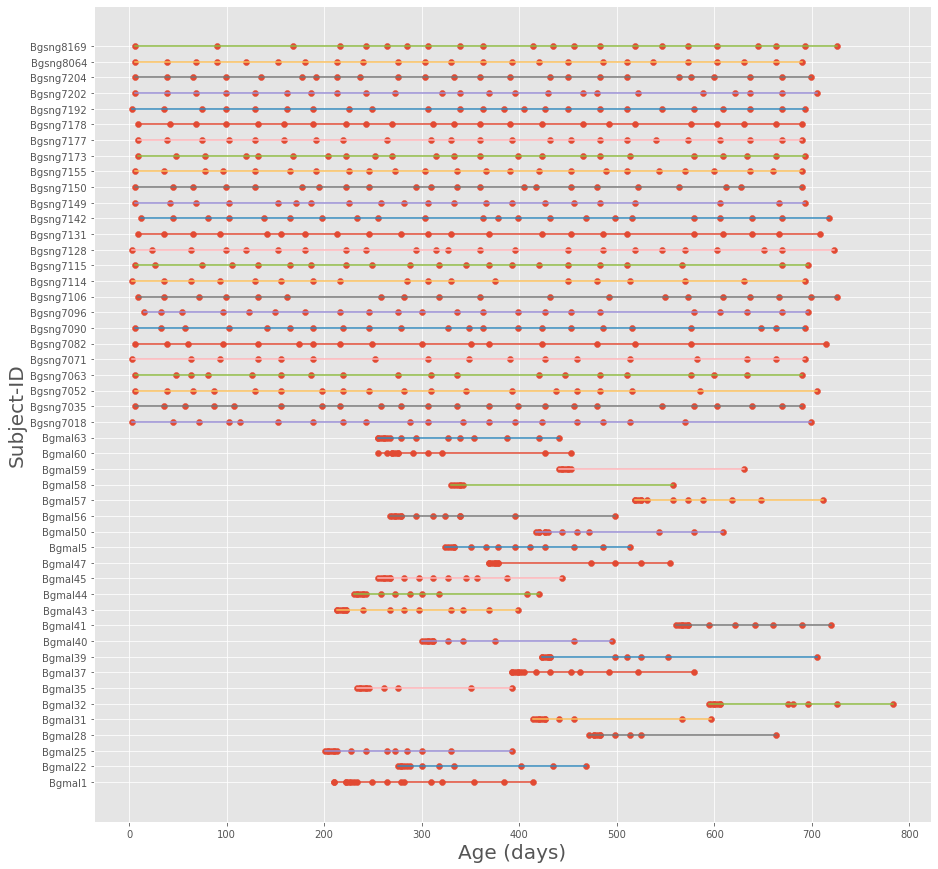

In [25]:
merged_singeltons_and_mal.plot_age_ranges()

In [30]:
singeltons_distance = distance.calculate_bray_curtis_table(singeltons_only_raw.abundance,singeltons_only_raw.abundance)

In [748]:
merged_raw_distance = distance.calculate_bray_curtis_table(merged_raw.abundance,merged_raw.abundance)

In [41]:
merged_singeltons_and_mal_distance = distance.calculate_bray_curtis_table(merged_singeltons_and_mal.abundance,merged_singeltons_and_mal.abundance)

In [44]:
healthy_subjects = healthy_dense_data.ages["Subject_ID"].unique()
malnourished_subjects = malnourished_only_raw.ages["Subject_ID"].unique()

In [31]:
healthy_singeltons = metadata[metadata["Health_Analysis_Groups"].isin(["Healthy Singletons"])]["Subject_ID"]
healthy_all = metadata[metadata["Health_Analysis_Groups"].isin(["Healthy Singletons","Healthy Twins Triplets"])]["Subject_ID"]
healthy_singeltons.unique()

array(['Bgsng7035', 'Bgsng7106', 'Bgsng7115', 'Bgsng7128', 'Bgsng7150',
       'Bgsng7155', 'Bgsng7177', 'Bgsng7192', 'Bgsng7202', 'Bgsng7204',
       'Bgsng8064', 'Bgsng8169', 'Bgsng7018', 'Bgsng7052', 'Bgsng7063',
       'Bgsng7071', 'Bgsng7082', 'Bgsng7090', 'Bgsng7096', 'Bgsng7114',
       'Bgsng7131', 'Bgsng7142', 'Bgsng7149', 'Bgsng7173', 'Bgsng7178'],
      dtype=object)

In [45]:
malnourished = metadata[metadata["Health_Analysis_Groups"].isin(["Severe Acute Malnutrition Study"])]["Subject_ID"].unique()

In [51]:
true = []
predicted = []
sems = []
subject_id = []
sample_id = []
indices = []
flip=False
# data=merged
# distance_matrix=merged_distance.T
data=merged_singeltons_and_mal
distance_matrix=merged_singeltons_and_mal_distance.T
subjects_in_data = data.ages["Subject_ID"].unique()
for subject1 in malnourished_subjects: 
    print(subject1)
# for subject1 in healthy_subjects:
    all_predictions = pd.DataFrame(columns=["predicted_age", "alignment_score"], dtype=float)
#     for subject2 in healthy_subjects:
    for subject2 in [s for s in healthy_singeltons if s!=subject1]:
#         samples1, samples2 = data.sample_ids_by_subject(subject1), data.sample_ids_by_subject(subject2)
        samples1, samples2 = data.sample_ids_by_subject(subject1), data.sample_ids_by_subject(subject2)
        if flip:
            samples1 = np.flip(samples1)
            samples2 = np.flip(samples2)
        predictions = age_analysis.predict_ages(samples1, samples2, data, distance_matrix, measurements=None, config=empty_config, how="all", alignemnt_method="open_begin_end", input_type="distance")
        all_predictions = pd.concat([all_predictions,predictions])
#         print(all_predictions)
    all_predictions.index.rename("index", inplace=True)
    mean_predictions = all_predictions.drop("alignment_score", axis=1).groupby("index").mean()
    sem_predictions = all_predictions.drop("alignment_score", axis=1).groupby("index").sem()
    ages1 = data.get_ages_of_samples(samples1)
    all_df = pd.concat([ages1,mean_predictions,sem_predictions],axis=1)
    true += list(all_df.iloc[:,0])
    indices += range(len(ages1))
    subject_id += [subject1 for age in ages1]
    sample_id += list(all_df.index)
    predicted += list(all_df.iloc[:,1])
    sems += list(all_df.iloc[:,2])
#     print(pd.DataFrame([mean_predictions,ages1]).T)
results_mal = pd.DataFrame([indices,true, predicted, sems,subject_id,sample_id]).T
results_mal = results_mal.dropna()
results_mal.index = [i for i in range(len(results_mal[0]))]

Bgmal1
Bgmal22
Bgmal25
Bgmal28
Bgmal31
Bgmal32
Bgmal35
Bgmal37
Bgmal39
Bgmal40
Bgmal41
Bgmal43
Bgmal44
Bgmal45
Bgmal47
Bgmal5
Bgmal50
Bgmal56
Bgmal57
Bgmal58
Bgmal59
Bgmal60
Bgmal63


In [50]:
# A copy of the previous box with analisys of healthy only

true = []
predicted = []
sems = []
subject_id = []
sample_id = []
indices = []
flip=False
# data=merged
# distance_matrix=merged_distance.T
data=singeltons_only_raw
distance_matrix=singeltons_distance.T
subjects_in_data = data.ages["Subject_ID"].unique()
for subject1 in subjects_in_data: 
    print(subject1)
# for subject1 in healthy_subjects:
    all_predictions = pd.DataFrame(columns=["predicted_age", "alignment_score"], dtype=float)
#     for subject2 in healthy_subjects:
    for subject2 in [s for s in subjects_in_data if s!=subject1]:
#         samples1, samples2 = data.sample_ids_by_subject(subject1), data.sample_ids_by_subject(subject2)
        samples1, samples2 = data.sample_ids_by_subject(subject1), data.sample_ids_by_subject(subject2)
        if flip:
            samples1 = np.flip(samples1)
            samples2 = np.flip(samples2)
        predictions = age_analysis.predict_ages(samples1, samples2, data, distance_matrix, measurements=None, config=empty_config, how="all", alignemnt_method="open_begin_end", input_type="distance")
        all_predictions = pd.concat([all_predictions,predictions])
#         print(all_predictions)
    all_predictions.index.rename("index", inplace=True)
    mean_predictions = all_predictions.drop("alignment_score", axis=1).groupby("index").mean()
    sem_predictions = all_predictions.drop("alignment_score", axis=1).groupby("index").sem()
    ages1 = data.get_ages_of_samples(samples1)
    all_df = pd.concat([ages1,mean_predictions,sem_predictions],axis=1)
    true += list(all_df.iloc[:,0])
    indices += range(len(ages1))
    subject_id += [subject1 for age in ages1]
    sample_id += list(all_df.index)
    predicted += list(all_df.iloc[:,1])
    sems += list(all_df.iloc[:,2])
#     print(pd.DataFrame([mean_predictions,ages1]).T)
results_healthy = pd.DataFrame([indices,true, predicted, sems,subject_id,sample_id]).T
results_healthy = results_healthy.dropna()
results_healthy.index = [i for i in range(len(results_healthy[0]))]

Bgsng7018
Bgsng7035
Bgsng7052
Bgsng7063
Bgsng7071
Bgsng7082
Bgsng7090
Bgsng7096
Bgsng7106
Bgsng7114
Bgsng7115
Bgsng7128
Bgsng7131
Bgsng7142
Bgsng7149
Bgsng7150
Bgsng7155
Bgsng7173
Bgsng7177
Bgsng7178
Bgsng7192
Bgsng7202
Bgsng7204
Bgsng8064
Bgsng8169


In [791]:
def color_by_phase(phase):
    if phase=="Treatment":
        return "b"
    if phase=="Acute Phase":
        return "r"
    if "follow" in phase:
        return "g"
    


In [53]:
results_mal["diff"] = results_mal.iloc[:,2]-results_mal.iloc[:,1]
results_healthy["diff"] = results_healthy.iloc[:,2]-results_healthy.iloc[:,1]


In [47]:
results["diff"] = results.iloc[:,2]-results.iloc[:,1]
print(results)
results.columns=["indices","true","predicted","standart_error","subject","sample","diff"]
results_filtered = results[results["indices"]<=10]
results_grouped = results_filtered.iloc[:,[0,1,2,6]].groupby(by="indices").mean(numeric_only=False)
# results_grouped=results[0,1,"diff"]
# results_grouped=results.groupby(by=1).mean()

      0    1        2        3        4               5     diff
0     0  210  193.603  5.19932   Bgmal1       Bgmal1.s1 -16.3966
1     1  210  193.603  5.19932   Bgmal1       Bgmal1.s2 -16.3966
2     2  222  205.168  5.13311   Bgmal1       Bgmal1.s3 -16.8324
3     3  222  215.229  5.01356   Bgmal1  Bgmal1.s4.RUTF -6.77095
4     4  225  230.341  5.16852   Bgmal1  Bgmal1.s5.RUTF  5.34078
..   ..  ...      ...      ...      ...             ...      ...
283  10  339  205.618  4.61733  Bgmal63     Bgmal63.s14 -133.382
284  11  354  244.583  4.70996  Bgmal63     Bgmal63.s15 -109.417
285  12  387  262.415  4.90624  Bgmal63     Bgmal63.s16 -124.585
286  13  420  290.054  5.29184  Bgmal63     Bgmal63.s17 -129.946
287  14  441  310.803   5.1894  Bgmal63     Bgmal63.s18 -130.197

[288 rows x 7 columns]


In [793]:
def color_list(subject_results):
    x = list(subject_results.iloc[:,5])
    return [color_by_phase(phase) for phase in phase_data.query('SampleID in @x')["phase"]]

In [68]:
results_healthy.rename(columns={1:"true","true":"predicted",4:"subject"},inplace=True)

In [83]:
results_healthy.columns=["indices","true","predicted","sems","subject","sample","diff"]

In [798]:
results_with_phase = results.merge(phase_data,left_on="sample",right_on="SampleID")

Text(0, 0.5, 'Predicted age')

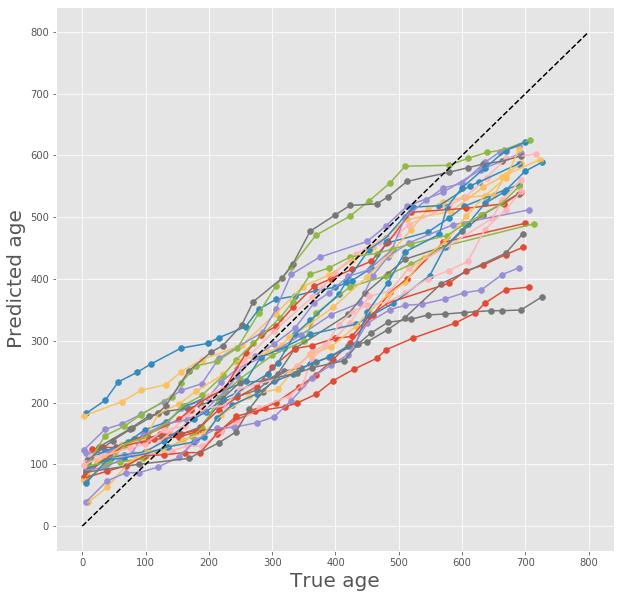

In [86]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 10)
results_with_phase=results_healthy
for subject in results_with_phase["subject"].unique():
    plt.scatter(results_with_phase[results_with_phase["subject"]==subject]["true"],results_with_phase[results_with_phase["subject"]==subject]["predicted"])
    plt.plot(results_with_phase[results_with_phase["subject"]==subject]["true"],results_with_phase[results_with_phase["subject"]==subject]["predicted"])
plt.plot([0,800],[0,800],c="black",linestyle="dashed")
plt.xlabel("True age",fontsize=20)
plt.ylabel("Predicted age",fontsize=20)

Text(0, 0.5, 'Predicted age')

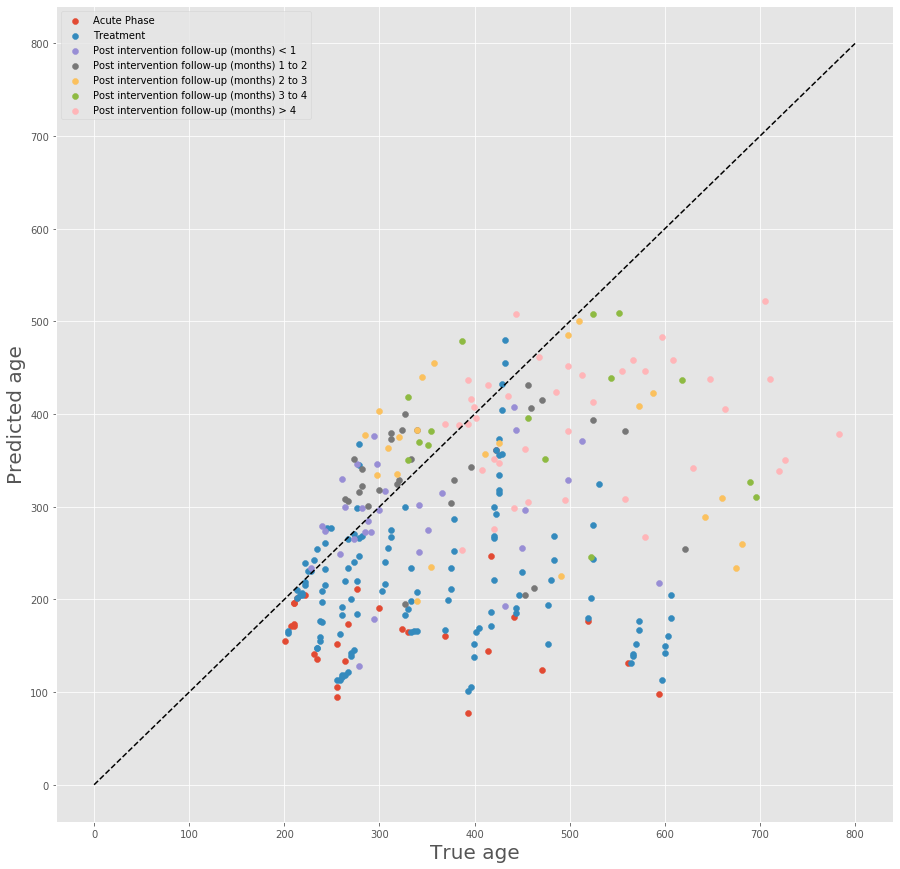

In [846]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15, 15)
for phase in results_with_phase["phase"].unique():
    plt.scatter(results_with_phase[results_with_phase["phase"]==phase]["true"],results_with_phase[results_with_phase["phase"]==phase]["predicted"],label=phase)
plt.plot([0,800],[0,800],c="black",linestyle="dashed")
plt.legend()
plt.xlabel("True age",fontsize=20)
plt.ylabel("Predicted age",fontsize=20)

In [813]:
results_grouped = results_with_phase.loc[:,["true","subject","predicted","diff","standart_error","phase"]].groupby(by=["subject","phase"]).last(numeric_only=False)


In [814]:
results_grouped=results_grouped.reset_index()
stats.mannwhitneyu(results_grouped[results_grouped["phase"]=="Acute Phase"]["diff"],results_grouped[results_grouped["phase"]=="Post intervention follow-up (months) < 1"]["diff"])

MannwhitneyuResult(statistic=87.0, pvalue=0.0004657312248801165)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Acute Phase v.s. Treatment: Mann-Whitney-Wilcoxon test smaller, P_val=1.053e-02 U_stat=1.590e+02
Acute Phase v.s. Post intervention follow-up (months) < 1: Mann-Whitney-Wilcoxon test smaller, P_val=4.657e-04 U_stat=8.700e+01
Acute Phase v.s. Post intervention follow-up (months) 1 to 2: Mann-Whitney-Wilcoxon test smaller, P_val=1.564e-03 U_stat=8.700e+01
Acute Phase v.s. Post intervention follow-up (months) 2 to 3: Mann-Whitney-Wilcoxon test smaller, P_val=1.752e-02 U_stat=8.500e+01
Acute Phase v.s. Post intervention follow-up (months) 3 to 4: Mann-Whitney-Wilcoxon test smaller, P_val=5.329e-02 U_stat=1.000e+02
Acute Phase v.s. Post intervention follow-up (months) > 4: Mann-Whitney-Wilcoxon test smaller, P_val=1.561e-01 U_stat=2.180e+02


Text(75.625, 0.5, 'True age - Predicted age')

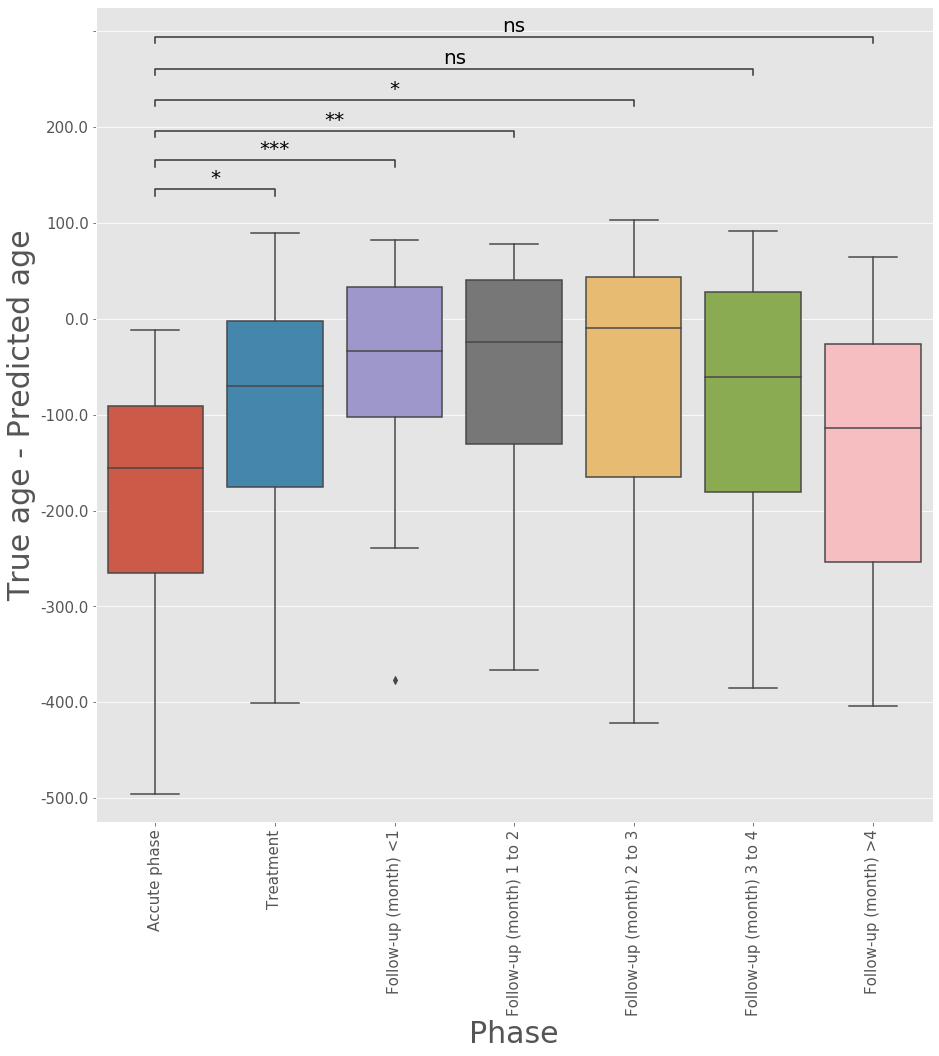

In [841]:
plt.style.use('ggplot')
ax = sns.boxplot(y='diff', x='phase', 
                 data=results_grouped,order=['Acute Phase', 'Treatment','Post intervention follow-up (months) < 1','Post intervention follow-up (months) 1 to 2',
       'Post intervention follow-up (months) 2 to 3',
       'Post intervention follow-up (months) 3 to 4',
       'Post intervention follow-up (months) > 4'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=15)
ax.set_yticklabels(ax.get_yticks(),fontsize=15)

add_stat_annotation(ax,data = results_grouped,y='diff', x='phase',order=['Acute Phase', 'Treatment','Post intervention follow-up (months) < 1','Post intervention follow-up (months) 1 to 2',
       'Post intervention follow-up (months) 2 to 3',
       'Post intervention follow-up (months) 3 to 4',
       'Post intervention follow-up (months) > 4'],
                    perform_stat_test=True,test="Mann-Whitney-ls",box_pairs=[('Acute Phase', 'Treatment'),('Acute Phase', 'Post intervention follow-up (months) < 1'),('Acute Phase', 'Post intervention follow-up (months) 1 to 2'),('Acute Phase', 'Post intervention follow-up (months) 2 to 3'),('Acute Phase','Post intervention follow-up (months) 3 to 4'),('Acute Phase','Post intervention follow-up (months) > 4')],text_format='star',comparisons_correction=None,
                    loc='inside', verbose=1,fontsize=20,linewidth=1.5,line_height=0.01,line_offset=0.01,)

locs, labels = plt.xticks()           
plt.xticks(locs, ["Accute phase","Treatment","Follow-up (month) <1","Follow-up (month) 1 to 2","Follow-up (month) 2 to 3","Follow-up (month) 3 to 4","Follow-up (month) >4"])
plt.xlabel("Phase",fontsize=30)
plt.ylabel("True age - Predicted age",fontsize=30)

# ax.set_xaxislabels(ax.get_xticklabels(),rotation=30,order=)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=30,order=)
# add_stat_annotation(ax,data = merged_results,y='score', x='pheno',hue="method",
#                     perform_stat_test=True,test="Mann-Whitney",box_pairs=[(("delivery","mean"),("delivery","alignment")),(("delivery","diagonal"),("delivery","alignment")),(("delivery","min"),("delivery","alignment")),
#                     (("diet","diagonal"),("diet","alignment")),(("diet","mean"),("diet","alignment")),(("diet","min"),("diet","alignment")),],text_format='star',comparisons_correction=None,
#                     loc='inside', verbose=0,fontsize=10,linewidth=1.5,line_height=0.01,line_offset=0.01,)